# Spark graph

In this tutorial, we show how to use spark to treat graph.

Suppose we have three files:
- doctors.csv : stores information of doctors
- patients.csv: stores information of patients
- doc_patient_relation.csv: stores information of relationship between doctors and patients

Q1. Build a bipartite graph with doctors on the left side and patients on the right side. 

Q2. List top 5 doctors who receive the most patients

Q3. List top 5 patients who see the most doctors

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc 
from graphframes import GraphFrame
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path

## Step1: Create a spark session

GraphX is build on Scala RDDs, which is hard to use. To facilitate the use of spark GraphX, we use an extra library called `GraphFrames` which provides GraphX data frame support and a list of pre-define functions, such as:
- degrees, 
- inDegrees, 
- outDegrees, 
- pageRank, 
- connectedComponents, 
- shortestPaths

In [2]:
spark = SparkSession.builder\
        .master("local[4]")\
        .appName("spark_graphX")\
        .config("spark.driver.memory", "4g")\
        .config('spark.jars.packages','graphframes:graphframes:0.8.4-spark3.5-s_2.12') \
        .getOrCreate()

## Step2: Read source data

In [3]:
data_path = Path().cwd().parent / 'data'
doc_path = data_path / 'doctors.csv'
patient_path = data_path / 'patients.csv'
relation_path = data_path / 'doc_patient_relation.csv'

In [4]:
doc_df = spark.read.csv(str(doc_path),header=True,inferSchema=True)
doc_df.show()

+---+-----------+--------------------+---+
| id|       name|               title|age|
+---+-----------+--------------------+---+
| D1|Carter_Frey|             dentist| 50|
| D2|May_Derrick|        pediatrician| 29|
| D3| Mills_Jeff|           ophthalmo| 80|
| D4|Hood_Robert|general_practitioner| 65|
| D5| Banks_Mike|             surgeon| 43|
| D6|   Berg_Tim|general_practitioner| 28|
| D7| Page_Allan|general_practitioner| 36|
| D8| Johny_Depp|             dentist| 50|
| D9|Wins_Carter|general_practitioner| 28|
+---+-----------+--------------------+---+



In [5]:
patient_df = spark.read.csv(str(patient_path),header=True,inferSchema=True)
patient_df.show()

+---+------------+-------+---+
| id|        name|  title|age|
+---+------------+-------+---+
| P1|     Foo_Bar|patient| 26|
| P2| May_Derrick|patient| 26|
| P3|Mills_Hammer|patient| 85|
| P4| Hood_Robert|patient| 65|
| P5|  Banks_Mike|patient| 93|
| P6|    Berg_Tim|patient| 28|
| P7|  Page_Allan|patient| 16|
| P8|     Foo_Bar|patient| 26|
| P9| May_Derrick|patient| 26|
|P10|  Mills_Jeff|patient| 80|
|P11| Hood_Robert|patient| 65|
|P12|  Banks_Mike|patient| 93|
|P13|    Berg_Tim|patient| 28|
|P14|  Page_Allan|patient|  6|
|P15| Jim_Cameron|patient| 26|
+---+------------+-------+---+



In [6]:
relation_df = spark.read.csv(str(relation_path),header=True,inferSchema=True)
relation_df.show()

+---+---+----------------+
|src|dst|            type|
+---+---+----------------+
| D1| P1|dental_operation|
| D1| P2|dental_operation|
| D1| P3|dental_operation|
| D1| P8|dental_operation|
| D1| P9|dental_operation|
| D1|P10|dental_operation|
| D2|P14|medecin_traitant|
| D3| P1|    oculoplastie|
| D4| P1|medecin_traitant|
| D4| P2|medecin_traitant|
| D4| P3|medecin_traitant|
| D4| P4|medecin_traitant|
| D5|P10| brain_operation|
| D5|P12| brain_operation|
| D6| P5|medecin_traitant|
| D6| P6|medecin_traitant|
| D6| P7|medecin_traitant|
| D6| P8|medecin_traitant|
| D7| P9|medecin_traitant|
| D7|P10|medecin_traitant|
+---+---+----------------+
only showing top 20 rows



## Step3: Build graph with GraphFrame

GraphX/GraphFrames are designed to handles `graphs with billions of nodes` on a distributed spark cluster. As a result, they do not provide `graph visualization`. In the below example, to visualize the graph, we convert the `GraphFrames` to `NetworkX`. 

> NetworkX is designed to run on single-machine, it will struggle if your graph has more than 100k nodes with 32GB memory.

In [7]:
edges_df = patient_df.union(doc_df)

graph = GraphFrame(edges_df,relation_df)

C:\Users\PLIU\Documents\git\seminar_spark\sp_venv\Lib\site-packages\pyspark\sql\dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


In [8]:
def build_edges_labels(edges_df)->dict:
    """
    This function converts a spark dataframe(edges of the graph) into a python dictionary, the key is (src,dst), the value is type
    :param edges_df: 
    :return: 
    """
    return {(row["src"], row["dst"]): row["type"] for row in edges_df}

def draw_graph(graph_frame: GraphFrame, directed:bool=True):
    """
    This function draws a bipartite graph plot, with the given GraphFrame
    :param graph_frame: input GraphFrame
    :param directed: specify if the graph is directed or not
    :return: 
    """
    # Choose graph type
    nx_graph = nx.DiGraph() if directed else nx.Graph()

    # Collect edge data
    edges = graph_frame.edges.collect()
    edge_labels = build_edges_labels(edges)

    # Build graph
    src_nodes = set()
    dst_nodes = set()
    for edge in edges:
        src = edge["src"]
        dst = edge["dst"]
        src_nodes.add(src)
        dst_nodes.add(dst)
        nx_graph.add_edge(src, dst)

    # Ensure no node is missing from position map
    all_nodes = src_nodes.union(dst_nodes)

    # Assign positions: src on left (x=0), dst on right (x=1)
    pos = {}
    src_sorted = sorted(src_nodes)
    dst_sorted = sorted(dst_nodes)
    for i, node in enumerate(src_sorted):
        pos[node] = (0, i)
    for i, node in enumerate(dst_sorted):
        pos[node] = (1, i)

    # Create figure
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(nx_graph, pos, node_color='skyblue', node_size=700, edgecolors='black')
    nx.draw_networkx_edges(nx_graph, pos, arrowstyle='->' if directed else '-', arrows=directed, edge_color='gray', connectionstyle='arc3,rad=0.1')
    nx.draw_networkx_labels(nx_graph, pos, font_size=12, font_color='black')
    nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels, font_color='red', font_size=10)

    plt.title("Graph with Left-Right Node Separation", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

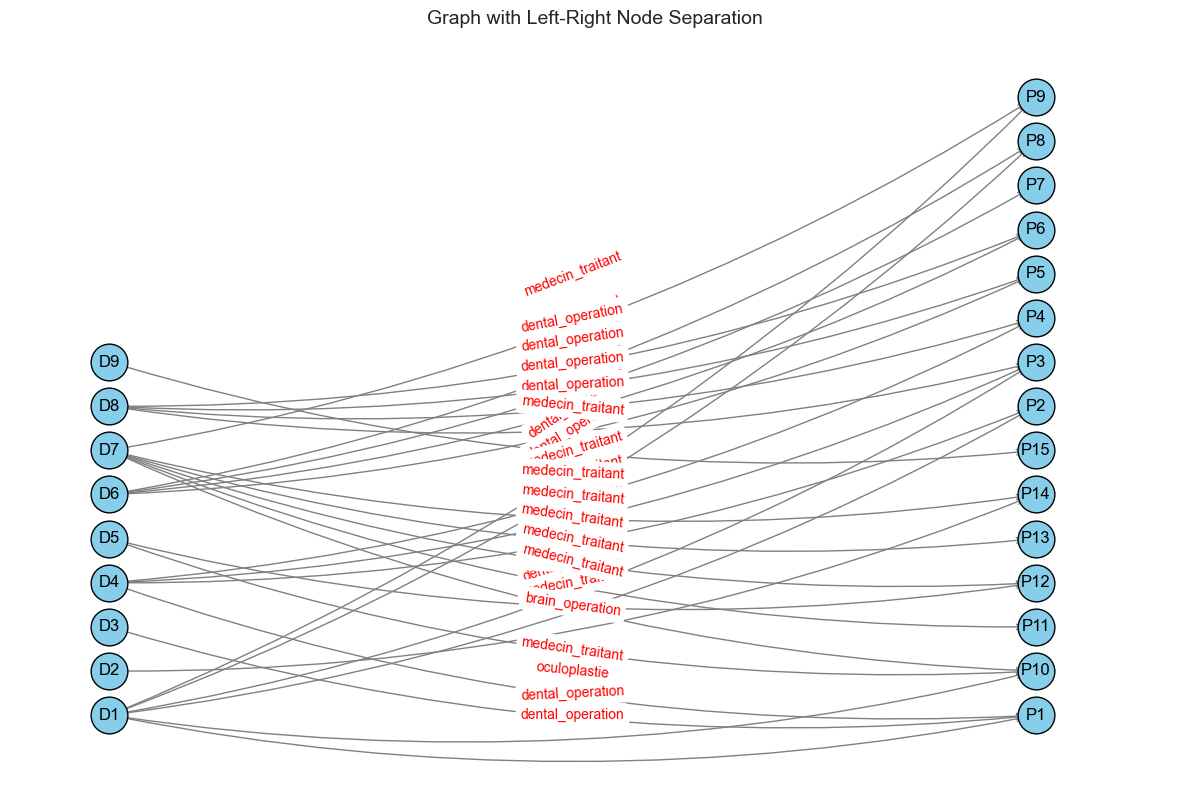

In [9]:
draw_graph(graph)

## Step4: Get the top 3 doctors


In [10]:
doc_patient_count = graph.outDegrees
# Join with doctor details for better output
doc_patient_count_df = doc_patient_count.join(doc_df, on="id").orderBy(desc("outDegree"))

# get the top 3 doctors who see the most patients
doc_patient_count_df.show(3)

C:\Users\PLIU\Documents\git\seminar_spark\sp_venv\Lib\site-packages\pyspark\sql\dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+---+---------+-----------+--------------------+---+
| id|outDegree|       name|               title|age|
+---+---------+-----------+--------------------+---+
| D7|        6| Page_Allan|general_practitioner| 36|
| D1|        6|Carter_Frey|             dentist| 50|
| D8|        4| Johny_Depp|             dentist| 50|
+---+---------+-----------+--------------------+---+
only showing top 3 rows



## Step5: Get the top 3 patients 

In [11]:
patient_see_doc_count = graph.inDegrees

# Join with patient details for better output
patient_see_doc_count_df = patient_see_doc_count.join(patient_df, on="id").orderBy(desc("inDegree"))

patient_see_doc_count_df.show(5)

+---+--------+------------+-------+---+
| id|inDegree|        name|  title|age|
+---+--------+------------+-------+---+
| P3|       3|Mills_Hammer|patient| 85|
|P10|       3|  Mills_Jeff|patient| 80|
| P1|       3|     Foo_Bar|patient| 26|
| P5|       2|  Banks_Mike|patient| 93|
| P2|       2| May_Derrick|patient| 26|
+---+--------+------------+-------+---+
only showing top 5 rows



## Step 6: find indirect relationships

We can also use graph to find indirect relationships. In below example, we detect when two doctors are treating the same patient or group of patients. The result can be used for potential collaboration or avoid conflict of interest.

In [12]:
motifs = graph.find("(d1)-[e1]->(p); (d2)-[e2]->(p)") \
              .filter("d1.id != d2.id")  # Avoid self-links

motifs.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                  d1|                  e1|                   p|                  d2|                  e2|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|{D1, Carter_Frey,...|{D1, P10, dental_...|{P10, Mills_Jeff,...|{D7, Page_Allan, ...|{D7, P10, medecin...|
|{D1, Carter_Frey,...|{D1, P10, dental_...|{P10, Mills_Jeff,...|{D5, Banks_Mike, ...|{D5, P10, brain_o...|
|{D1, Carter_Frey,...|{D1, P9, dental_o...|{P9, May_Derrick,...|{D7, Page_Allan, ...|{D7, P9, medecin_...|
|{D1, Carter_Frey,...|{D1, P8, dental_o...|{P8, Foo_Bar, pat...|{D6, Berg_Tim, ge...|{D6, P8, medecin_...|
|{D1, Carter_Frey,...|{D1, P3, dental_o...|{P3, Mills_Hammer...|{D8, Johny_Depp, ...|{D8, P3, dental_o...|
|{D1, Carter_Frey,...|{D1, P3, dental_o...|{P3, Mills_Hammer...|{D4, Hood_Robert,...|{D4, P3, medecin_...|
|{D1, Carter_Frey,...|{D1, P2, dental

## Step 7:  Identify influential doctors or central patients.

PageRank points out the `important` nodes in the graph. So we can use it to identify influential doctors or central patients.

In [13]:
ranks = graph.pageRank(resetProbability=0.15, maxIter=10)
ranks.vertices.orderBy("pagerank", ascending=False).show()

+---+------------+--------------------+---+------------------+
| id|        name|               title|age|          pagerank|
+---+------------+--------------------+---+------------------+
| P1|     Foo_Bar|             patient| 26|1.6714060031595575|
|P14|  Page_Allan|             patient|  6|1.5102685624012637|
|P15| Jim_Cameron|             patient| 26|1.4028436018957344|
|P10|  Mills_Jeff|             patient| 80|1.2954186413902053|
| P3|Mills_Hammer|             patient| 85| 1.187993680884676|
|P12|  Banks_Mike|             patient| 93| 1.187993680884676|
| P5|  Banks_Mike|             patient| 93| 1.080568720379147|
| P4| Hood_Robert|             patient| 65| 1.080568720379147|
| P6|    Berg_Tim|             patient| 28| 1.080568720379147|
| P8|     Foo_Bar|             patient| 26|1.0268562401263823|
| P2| May_Derrick|             patient| 26|1.0268562401263823|
| P9| May_Derrick|             patient| 26|0.9731437598736178|
| P7|  Page_Allan|             patient| 16|0.9194312796